## Temporal Fusion Transformer (TFT) Attempt

### Why We Considered It:
- TFT is a **state-of-the-art deep learning model** for **sequential data forecasting**.
- It integrates **multiple time-series features** and **handles long-range dependencies** better than traditional RNN-based models (LSTM/GRU).

In [32]:
import pandas as pd
import numpy as np
import torch
import pytorch_forecasting
import pytorch_lightning as pl
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [33]:
# Print PyTorch version
print(torch.__version__)

# Check if Apple Metal GPU backend (MPS) is available
print(f"MPS Available: {torch.backends.mps.is_available()}")

print("MPS Built:", torch.backends.mps.is_built())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


print("PyTorch Forecasting Installed:", "Success" if 'pytorch_forecasting' in dir() else "Failed")
print("PyTorch Lightning Version:", pl.__version__)

2.6.0
MPS Available: True
MPS Built: True
Using device: mps
PyTorch Forecasting Installed: Success
PyTorch Lightning Version: 2.5.0.post0


In [59]:
# Load the cleaned master dataset
df = pd.read_csv('dataset/cleaned_master_dataset.csv')

# Quick check
print(df.shape)
print(df.head())

(1080905, 81)
      timestamp  acc_x_dashboard_left  acc_y_dashboard_left  \
0  1.577219e+09              0.365116              0.167893   
1  1.577219e+09              0.392649              0.176273   
2  1.577219e+09              0.409408              0.181062   
3  1.577219e+09              0.371101              0.164302   
4  1.577219e+09              0.390255              0.159514   

   acc_z_dashboard_left  acc_x_above_suspension_left  \
0              9.793961                     0.327626   
1              9.771216                     0.381496   
2              9.732909                     0.283333   
3              9.749668                     0.314458   
4              9.869378                     0.344385   

   acc_y_above_suspension_left  acc_z_above_suspension_left  \
0                     0.172733                     9.781861   
1                     0.189492                     9.699261   
2                     0.182310                     9.807000   
3                 

## Some EDA here

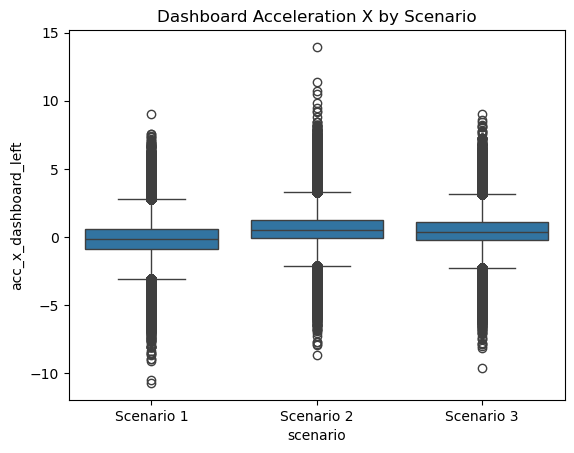

In [60]:
# Ex: Quick EDA - Visualize vibration data or vehicle-specific trends
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='scenario', y='acc_x_dashboard_left', data=df)
plt.title('Dashboard Acceleration X by Scenario')
plt.show()

In [61]:
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import GroupNormalizer, NaNLabelEncoder

# 📌 1. DATA PREPROCESSING
print("🔹 Starting Data Preprocessing...")

# ✅ Copy original dataset to avoid modifications
master_df = df.copy()

# ✅ Convert timestamp to integer index
master_df["timestamp"] = master_df["timestamp"].astype(int)

# ✅ Handle missing values in target column
master_df["speed_meters_per_second"] = master_df["speed_meters_per_second"].ffill().bfill()

# ✅ Ensure vehicle column has no missing values
master_df["vehicle"] = master_df["vehicle"].fillna("unknown")

# ✅ Print timestamp dtype for verification
print(f"✔️ Timestamp dtype: {master_df['timestamp'].dtype}")  # Should print 'int64'

# 📌 2. SPLITTING DATA INTO TRAIN & VALIDATION
print("\n🔹 Splitting Data...")

# ✅ Define time series parameters
max_prediction_length = 5  # Future steps to predict
max_encoder_length = 15  # History length

# ✅ Split dataset manually (80% train, 20% validation)
train_size = int(len(master_df) * 0.8)
train_df = master_df.iloc[:train_size]
val_df = master_df.iloc[train_size:]

# ✅ Remove fully empty sequences
train_df = train_df.dropna(how="all")
val_df = val_df.dropna(how="all")

# 📌 3. FILTERING SEQUENCES
print("\n🔹 Filtering sequences shorter than required length...")
train_df = train_df.groupby("vehicle").filter(lambda x: len(x) >= max_encoder_length + max_prediction_length)
val_df = val_df.groupby("vehicle").filter(lambda x: len(x) >= max_encoder_length + max_prediction_length)
print(f"✅ After filtering: {len(train_df)} training rows, {len(val_df)} validation rows")

# 📌 4. CHECKING UNIQUE TIMESTAMP COUNTS
print("\n🔹 Checking unique sequence lengths per vehicle...")
print(train_df.groupby("vehicle")["timestamp"].nunique().describe())
print(val_df.groupby("vehicle")["timestamp"].nunique().describe())

# 📌 5. DETECTING EMPTY COLUMNS
print("\n🔹 Checking for empty columns in train and validation sets...")
empty_columns_train = train_df.columns[train_df.isna().all()]
empty_columns_val = val_df.columns[val_df.isna().all()]
print(f"❌ Empty columns in train set: {list(empty_columns_train)}")
print(f"❌ Empty columns in validation set: {list(empty_columns_val)}")

# ✅ Removing completely empty columns
if "activity" in train_df.columns:
    print("🚀 Removing empty column 'activity' from train and validation sets.")
    train_df = train_df.drop(columns=["activity"])
    val_df = val_df.drop(columns=["activity"])

# 📌 6. VERIFYING KEY COLUMNS HAVE DATA
print("\n🔹 Checking if `time_varying_unknown_reals` columns contain data...")
for col in ["acc_x_dashboard_left", "acc_y_dashboard_left"]:
    print(f"🔹 {col} - Missing values: {train_df[col].isna().sum()} / {len(train_df)}")

# 📌 7. VERIFYING EMPTY SEQUENCES
print("\n🔹 Checking for empty sequences before creating TimeSeriesDataSet...")
empty_sequences_train = train_df.groupby("vehicle").filter(lambda x: len(x) == 0)
empty_sequences_val = val_df.groupby("vehicle").filter(lambda x: len(x) == 0)
print(f"❌ Empty sequences in training set: {len(empty_sequences_train)}")
print(f"❌ Empty sequences in validation set: {len(empty_sequences_val)}")

# 📌 8. CREATING TIME SERIES DATASETS
print("\n🔹 Creating TimeSeriesDataSet for training & validation...")

train_dataset = TimeSeriesDataSet(
    train_df,
    time_idx="timestamp",
    target="speed_meters_per_second",
    group_ids=["vehicle"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["timestamp"],
    time_varying_unknown_reals=["acc_x_dashboard_left", "acc_y_dashboard_left"],
    target_normalizer=GroupNormalizer(groups=["vehicle"]),
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    categorical_encoders={"vehicle": NaNLabelEncoder(add_nan=True)},  # Handles missing categories
)

val_dataset = TimeSeriesDataSet(
    val_df,
    time_idx="timestamp",
    target="speed_meters_per_second",
    group_ids=["vehicle"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["timestamp"],
    time_varying_unknown_reals=["acc_x_dashboard_left", "acc_y_dashboard_left"],
    target_normalizer=GroupNormalizer(groups=["vehicle"]),
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    categorical_encoders={"vehicle": NaNLabelEncoder(add_nan=True)},
)

# 📌 9. FINAL OUTPUT
print("\n✅ Final dataset sizes:")
print(f"📊 Train dataset size: {len(train_dataset)}")
print(f"📊 Validation dataset size: {len(val_dataset)}")

🔹 Starting Data Preprocessing...
✔️ Timestamp dtype: int64

🔹 Splitting Data...

🔹 Filtering sequences shorter than required length...
✅ After filtering: 864724 training rows, 216181 validation rows

🔹 Checking unique sequence lengths per vehicle...
count       3.000000
mean     2884.000000
std      1393.818137
min      1276.000000
25%      2452.500000
50%      3629.000000
75%      3688.000000
max      3747.000000
Name: timestamp, dtype: float64
count       1.0
mean     2164.0
std         NaN
min      2164.0
25%      2164.0
50%      2164.0
75%      2164.0
max      2164.0
Name: timestamp, dtype: float64

🔹 Checking for empty columns in train and validation sets...
❌ Empty columns in train set: ['activity']
❌ Empty columns in validation set: ['activity']
🚀 Removing empty column 'activity' from train and validation sets.

🔹 Checking if `time_varying_unknown_reals` columns contain data...
🔹 acc_x_dashboard_left - Missing values: 0 / 864724
🔹 acc_y_dashboard_left - Missing values: 0 / 86472

In [63]:
from torch.utils.data import DataLoader

# ✅ Step 0: Check for empty features in train_df before DataLoader
print("\n🔹 Checking for empty features in train dataset...")
for key in train_df.columns:
    num_missing = train_df[key].isna().sum()
    num_zeros = (train_df[key] == 0).sum()
    print(f"🔹 {key}: Missing values = {num_missing}, Zero values = {num_zeros}")

# ✅ Step 1: Check unique sequence lengths
print("\n✅ Checking unique sequence lengths in train dataset (filtered):")
train_sequence_lengths = train_df.groupby("vehicle")["timestamp"].nunique()
print(train_sequence_lengths.describe())  

print("\n✅ Checking unique sequence lengths in validation dataset (filtered):")
val_sequence_lengths = val_df.groupby("vehicle")["timestamp"].nunique()
print(val_sequence_lengths.describe())

# ✅ Step 2: Define batch size
batch_size = 128

# ✅ Step 3: Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"\n✅ Train DataLoader batches: {len(train_dataloader)}")
print(f"✅ Validation DataLoader batches: {len(val_dataloader)}")

# ✅ Step 4: Debug DataLoader fetching
print("\n✅ Checking first batch from DataLoader...")

try:
    first_batch = next(iter(train_dataloader))
    print("✅ Successfully fetched a batch")
    print("🔹 Batch Keys:", first_batch.keys())

    for key, value in first_batch.items():
        print(f"   🔹 {key}: Shape = {value.shape if isinstance(value, torch.Tensor) else type(value)}")

except Exception as e:
    print("❌ Error fetching batch:", e)


🔹 Checking for empty features in train dataset...
🔹 timestamp: Missing values = 0, Zero values = 0
🔹 acc_x_dashboard_left: Missing values = 0, Zero values = 93
🔹 acc_y_dashboard_left: Missing values = 0, Zero values = 21
🔹 acc_z_dashboard_left: Missing values = 0, Zero values = 3
🔹 acc_x_above_suspension_left: Missing values = 0, Zero values = 3
🔹 acc_y_above_suspension_left: Missing values = 0, Zero values = 3
🔹 acc_z_above_suspension_left: Missing values = 0, Zero values = 3
🔹 acc_x_below_suspension_left: Missing values = 0, Zero values = 3
🔹 acc_y_below_suspension_left: Missing values = 0, Zero values = 3
🔹 acc_z_below_suspension_left: Missing values = 0, Zero values = 3
🔹 gyro_x_dashboard_left: Missing values = 0, Zero values = 1053
🔹 gyro_y_dashboard_left: Missing values = 0, Zero values = 3
🔹 gyro_z_dashboard_left: Missing values = 0, Zero values = 3
🔹 gyro_x_above_suspension_left: Missing values = 0, Zero values = 3
🔹 gyro_y_above_suspension_left: Missing values = 0, Zero value

More cleaning

In [69]:
# 📌 CELL 3: Aggressive Data Cleaning & Preparing Data for TFT

import numpy as np

print("\n🔹 Starting Aggressive Data Cleaning Process...")

# ✅ Step 1: Identify columns to drop (ONLY if completely useless)
high_missing_cols = ["elevation", "satellites", "hdop", "vdop", "pdop", 
                     "distance_meters", "elapsed_time_seconds"]

print(f"🚀 Dropping high-missing-value columns: {high_missing_cols}")

train_df_cleaned = train_df.drop(columns=high_missing_cols, errors="ignore")
val_df_cleaned = val_df.drop(columns=high_missing_cols, errors="ignore")

# ✅ Step 2: Fill remaining missing values intelligently
# Forward-fill first, then back-fill as a safety net
train_df_cleaned.fillna(method="ffill", inplace=True)
train_df_cleaned.fillna(method="bfill", inplace=True)

val_df_cleaned.fillna(method="ffill", inplace=True)
val_df_cleaned.fillna(method="bfill", inplace=True)

# **NEW**: Fill any remaining NaNs with the median value of each column
for col in train_df_cleaned.columns:
    if train_df_cleaned[col].isna().sum() > 0:
        median_value = train_df_cleaned[col].median()
        train_df_cleaned[col].fillna(median_value, inplace=True)

for col in val_df_cleaned.columns:
    if val_df_cleaned[col].isna().sum() > 0:
        median_value = val_df_cleaned[col].median()
        val_df_cleaned[col].fillna(median_value, inplace=True)

# ✅ Step 3: Replace zero values in key features to prevent model breakage
zero_replacement_cols = ["speed_meters_per_second", "acc_x_dashboard_left", "acc_y_dashboard_left"]
for col in zero_replacement_cols:
    train_df_cleaned[col] = train_df_cleaned[col].replace(0, train_df_cleaned[col].median())
    val_df_cleaned[col] = val_df_cleaned[col].replace(0, val_df_cleaned[col].median())

# ✅ Step 4: Ensure sequences are still valid
print("\n🔹 Verifying sequence lengths after aggressive cleaning...")

train_df_cleaned = train_df_cleaned.groupby("vehicle").filter(lambda x: len(x) >= max_encoder_length + max_prediction_length)
val_df_cleaned = val_df_cleaned.groupby("vehicle").filter(lambda x: len(x) >= max_encoder_length + max_prediction_length)

print(f"✅ After cleaning: {len(train_df_cleaned)} training rows, {len(val_df_cleaned)} validation rows")

# ✅ Step 5: Re-create TimeSeriesDataSet with cleaned data
print("\n🔹 Creating new TimeSeriesDataSet with aggressively cleaned data...")

train_dataset_cleaned = TimeSeriesDataSet(
    train_df_cleaned,
    time_idx="timestamp",
    target="speed_meters_per_second",
    group_ids=["vehicle"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["timestamp"],
    time_varying_unknown_reals=["acc_x_dashboard_left", "acc_y_dashboard_left"],
    static_categoricals=["vehicle"],  # ✅ Add this line to define `vehicle` as a categorical feature
    target_normalizer=GroupNormalizer(groups=["vehicle"]),
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    group_ids=["vehicle"],
    categorical_encoders={"vehicle": NaNLabelEncoder(add_nan=True)},  # Handles missing categories
)

val_dataset_cleaned = TimeSeriesDataSet(
    val_df_cleaned,
    time_idx="timestamp",
    target="speed_meters_per_second",
    group_ids=["vehicle"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["timestamp"],
    time_varying_unknown_reals=["acc_x_dashboard_left", "acc_y_dashboard_left"],
    static_categoricals=["vehicle"],  # ✅ Add this line here too
    target_normalizer=GroupNormalizer(groups=["vehicle"]),
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_target_scales=True,
    group_ids=["vehicle"],
    categorical_encoders={"vehicle": NaNLabelEncoder(add_nan=True)},
)

# ✅ Step 6: Final Dataset Validation
print("\n✅ Final cleaned dataset sizes:")
print(f"📊 Train dataset size: {len(train_dataset_cleaned)}")
print(f"📊 Validation dataset size: {len(val_dataset_cleaned)}")


🔹 Starting Aggressive Data Cleaning Process...
🚀 Dropping high-missing-value columns: ['elevation', 'satellites', 'hdop', 'vdop', 'pdop', 'distance_meters', 'elapsed_time_seconds']


/var/folders/3y/9mpx5xp50f9chfv2mgfnsmmr0000gn/T/ipykernel_32121/1449649126.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df_cleaned.fillna(method="ffill", inplace=True)
/var/folders/3y/9mpx5xp50f9chfv2mgfnsmmr0000gn/T/ipykernel_32121/1449649126.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df_cleaned.fillna(method="bfill", inplace=True)
/var/folders/3y/9mpx5xp50f9chfv2mgfnsmmr0000gn/T/ipykernel_32121/1449649126.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  val_df_cleaned.fillna(method="ffill", inplace=True)
/var/folders/3y/9mpx5xp50f9chfv2mgfnsmmr0000gn/T/ipykernel_32121/1449649126.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version


🔹 Verifying sequence lengths after aggressive cleaning...
✅ After cleaning: 864724 training rows, 216181 validation rows

🔹 Creating new TimeSeriesDataSet with aggressively cleaned data...


SyntaxError: keyword argument repeated: group_ids (1449649126.py, line 66)

In [73]:
# 📌 CELL 4: Debugging Before DataLoader Creation

print("\n🔹 Extracting a SMALL dataset sample for debugging...")

# ✅ Set Debugging Sample Size (e.g., 50,000 for performance)
DEBUG_SAMPLE_SIZE = 100_000

# ✅ Extract a smaller dataset sample instead of full dataset
train_data_dict = train_dataset_cleaned.to_dataloader(batch_size=DEBUG_SAMPLE_SIZE).dataset.data
val_data_dict = val_dataset_cleaned.to_dataloader(batch_size=DEBUG_SAMPLE_SIZE).dataset.data

# ✅ Debug: Check structure of extracted dictionary
print("\n🔍 Checking column lengths in Train dataset (Debug Sample)...")
for key, value in train_data_dict.items():
    if value is None:
        print(f"❌ Warning: Column {key} is None!")
    else:
        print(f"🔹 Column: {key}, Shape: {value.shape if hasattr(value, 'shape') else len(value)}")

print("\n🔍 Checking column lengths in Validation dataset (Debug Sample)...")
for key, value in val_data_dict.items():
    if value is None:
        print(f"❌ Warning: Column {key} is None!")
    else:
        print(f"🔹 Column: {key}, Shape: {value.shape if hasattr(value, 'shape') else len(value)}")

# ✅ Step 1: Drop Unnecessary Columns (`reals`, `groups`, `categoricals`)
# columns_to_drop = ["reals", "groups", "categoricals"]

# for col in columns_to_drop:
#     if col in train_data_dict:
#         print(f"🗑️ Dropping `{col}` from Train dataset...")
#         del train_data_dict[col]
#     if col in val_data_dict:
#         print(f"🗑️ Dropping `{col}` from Validation dataset...")
#         del val_data_dict[col]

# print("\n✅ `reals`, `groups`, and `categoricals` successfully removed from both datasets!")

# ✅ Print Before Fixing `categoricals`
for dataset_name, dataset_dict in [("train", train_data_dict), ("val", val_data_dict)]:
    if "categoricals" in dataset_dict:
        print(f"🔍 BEFORE FIX: `{dataset_name}.categoricals` shape = {dataset_dict['categoricals'].shape}")

# ✅ Ensure `categoricals` is 2D and has at least one column
for dataset_name, dataset_dict in [("train", train_data_dict), ("val", val_data_dict)]:
    if "categoricals" in dataset_dict:
        if dataset_dict["categoricals"].size == 0:  # If it's an empty (N,0) tensor
            dataset_dict["categoricals"] = torch.zeros((len(dataset_dict["target"]), 1))  # Add one column of zeros
        
        print(f"✅ AFTER FIX: `{dataset_name}.categoricals` shape = {dataset_dict['categoricals'].shape}")


# ✅ Final check: Ensure `reals` is removed before creating DataLoaders
print("\n🔍 Final dataset keys before DataLoader creation:")
print("🔹 Train dataset keys:", list(train_data_dict.keys()))
print("🔹 Validation dataset keys:", list(val_data_dict.keys()))


# ✅ Remove NoneType values before checking length
train_data_dict = {k: v for k, v in train_data_dict.items() if v is not None}
val_data_dict = {k: v for k, v in val_data_dict.items() if v is not None}

# 🚨 **Step 2: Detect & Remove Empty Columns**
print("\n🔍 Checking for empty or incorrect columns before DataFrame creation...")
columns_to_remove = []
for dataset_name, dataset_dict in [("train", train_data_dict), ("val", val_data_dict)]:
    for key, value in dataset_dict.items():
        if isinstance(value, np.ndarray):
            print(f"   🔹 `{dataset_name}.{key}`: Shape = {value.shape}")

            # 🚨 Remove empty or malformed columns
            if value.size == 0 or value.shape in [(), (1, 0)]:
                print(f"🚨 WARNING: `{key}` in {dataset_name} is EMPTY or malformed! Removing column.")
                columns_to_remove.append((dataset_name, key))

# 🚨 **Remove Problematic Columns**
for dataset_name, key in columns_to_remove:
    if dataset_name == "train":
        del train_data_dict[key]
    else:
        del val_data_dict[key]

# ✅ Step 3: Fix `target` Column (Flatten & Convert)
for dataset_name, dataset_dict in [("train", train_data_dict), ("val", val_data_dict)]:
    if "target" in dataset_dict:
        if isinstance(dataset_dict["target"], list) and len(dataset_dict["target"]) == 1:
            print(f"🔄 Fixing `target` in {dataset_name} dataset: Extracting tensor...")
            dataset_dict["target"] = dataset_dict["target"][0]  # Extract tensor
        
        if isinstance(dataset_dict["target"], torch.Tensor):
            print(f"🔄 Converting `target` tensor to NumPy array in {dataset_name} dataset...")
            dataset_dict["target"] = dataset_dict["target"].cpu().numpy()  # Convert to NumPy
        
        if dataset_dict["target"].ndim > 1:
            print(f"⚠️ `target` in {dataset_name} is multi-dimensional ({dataset_dict['target'].shape}), flattening...")
            dataset_dict["target"] = dataset_dict["target"].reshape(-1)  # Flatten to 1D

print("\n✅ `target` column successfully fixed for both datasets!")

# # 🚨 **Step 3: Fix `groups` & `time` Columns**
# for dataset_name, dataset_dict in [("train", train_data_dict), ("val", val_data_dict)]:
#     for key in dataset_dict.keys():
#         if isinstance(dataset_dict[key], np.ndarray):
#             # 🚨 Fix `groups` column
#             if key == "groups":
#                 if dataset_dict[key].ndim == 0 or dataset_dict[key].shape == ():
#                     print(f"⚠️ WARNING: `{key}` in {dataset_name} is scalar! Converting to 1D array...")
#                     dataset_dict[key] = np.array([dataset_dict[key]])  # Convert to array

#             # 🚨 Fix `time` column
#             if key == "time":
#                 if dataset_dict[key].ndim != 1:
#                     print(f"⚠️ WARNING: `{key}` in {dataset_name} is not 1D! Flattening...")
#                     dataset_dict[key] = dataset_dict[key].reshape(-1)  # Force 1D shape
            
#             # 🚨 Catch remaining multi-dimensional issues
#             if dataset_dict[key].ndim > 1:
#                 print(f"⚠️ Column `{key}` in {dataset_name} is multi-dimensional ({dataset_dict[key].shape}), flattening...")
#                 dataset_dict[key] = dataset_dict[key].reshape(-1)  # Flatten to 1D

# ✅ **Step 4: Trim Dataset Lengths for Consistency**
print("\n🔍 Checking dataset length consistency before trimming...")

# 🚀 Print dataset keys
print("\n🔹 Train dataset keys:", list(train_data_dict.keys()))
print("🔹 Validation dataset keys:", list(val_data_dict.keys()))

# 🚀 Print each column's length before calculating min length
print("\n🔍 Train dataset column lengths:")
for key, value in train_data_dict.items():
    if isinstance(value, np.ndarray):
        print(f"   - `{key}`: Length = {len(value)} | Shape = {value.shape}")
    else:
        print(f"   - `{key}`: Type = {type(value)} (Not an ndarray)")

print("\n🔍 Validation dataset column lengths:")
for key, value in val_data_dict.items():
    if isinstance(value, np.ndarray):
        print(f"   - `{key}`: Length = {len(value)} | Shape = {value.shape}")
    else:
        print(f"   - `{key}`: Type = {type(value)} (Not an ndarray)")


# 🚀 **Step 4.1: Print First 5 Records for Each Column**
print("\n🔍 Inspecting first 5 records for each feature in TRAIN dataset:")

for key, value in train_data_dict.items():
    try:
        print(f"\n🔹 Feature: `{key}`")
        
        if isinstance(value, torch.Tensor):
            print(value[:5].cpu().numpy())  # Convert tensor to NumPy and print first 5 records
        elif isinstance(value, np.ndarray):
            print(value[:5])  # Directly print first 5 records
        elif isinstance(value, list):
            print(value[:5])  # Print first 5 records if it's a list
        else:
            print(f"❌ Unexpected data type: {type(value)}")
    
    except Exception as e:
        print(f"❌ Error accessing `{key}`:", e)

print("\n✅ Final `categoricals` Shape in Train Dataset:", train_data_dict["categoricals"].shape)

# Step 4.2: Repeat for Validation Dataset
print("\n🔍 Inspecting first 5 records for each feature in VALIDATION dataset:")

for key, value in val_data_dict.items():
    try:
        print(f"\n🔹 Feature: `{key}`")
        
        if isinstance(value, torch.Tensor):
            print(value[:5].cpu().numpy())  # Convert tensor to NumPy and print first 5 records
        elif isinstance(value, np.ndarray):
            print(value[:5])  # Directly print first 5 records
        elif isinstance(value, list):
            print(value[:5])  # Print first 5 records if it's a list
        else:
            print(f"❌ Unexpected data type: {type(value)}")
    
    except Exception as e:
        print(f"❌ Error accessing `{key}`:", e)

print("\n✅ Feature inspection completed.")


# ✅ Temporarily remove `categoricals` and `groups` before DataFrame conversion 
# (since Pandas doesn't support 2D arrays)
train_data_dict_for_df = {
    k: v.cpu().numpy() if isinstance(v, torch.Tensor) else v 
    for k, v in train_data_dict.items() if k not in ["reals", "categoricals", "groups"]
}
val_data_dict_for_df = {
    k: v.cpu().numpy() if isinstance(v, torch.Tensor) else v 
    for k, v in val_data_dict.items() if k not in ["reals", "categoricals", "groups"]
}

try:
    train_df_debug = pd.DataFrame.from_dict(train_data_dict_for_df).sample(10)
    val_df_debug = pd.DataFrame.from_dict(val_data_dict_for_df).sample(10)
    print("✅ DataFrame created successfully!")
except ValueError as e:
    print("\n❌ ERROR: Could not create Pandas DataFrame! The dataset is likely empty.", e)
    raise e

# ✅ **Step 6: Print Final Debugging Info**
print("\n🔹 Train dataset sample:")
print(train_df_debug)

print("\n🔹 Validation dataset sample:")
print(val_df_debug)

# ✅ **Check for missing values**
print("\n🔹 Checking for missing values in Train dataset...")
print(train_df_debug.isna().sum())

print("\n🔹 Checking for missing values in Validation dataset...")
print(val_df_debug.isna().sum())

print("\n✅ Data extraction and alignment completed successfully!")


🔹 Extracting a SMALL dataset sample for debugging...

🔍 Checking column lengths in Train dataset (Debug Sample)...
🔹 Column: reals, Shape: torch.Size([864724, 6])
🔹 Column: categoricals, Shape: torch.Size([864724, 1])
🔹 Column: groups, Shape: torch.Size([864724, 1])
🔹 Column: target, Shape: 1
❌ Warning: Column weight is None!
🔹 Column: time, Shape: torch.Size([864724])

🔍 Checking column lengths in Validation dataset (Debug Sample)...
🔹 Column: reals, Shape: torch.Size([216181, 6])
🔹 Column: categoricals, Shape: torch.Size([216181, 1])
🔹 Column: groups, Shape: torch.Size([216181, 1])
🔹 Column: target, Shape: 1
❌ Warning: Column weight is None!
🔹 Column: time, Shape: torch.Size([216181])
🔍 BEFORE FIX: `train.categoricals` shape = torch.Size([864724, 1])
🔍 BEFORE FIX: `val.categoricals` shape = torch.Size([216181, 1])
✅ AFTER FIX: `train.categoricals` shape = torch.Size([864724, 1])
✅ AFTER FIX: `val.categoricals` shape = torch.Size([216181, 1])

🔍 Final dataset keys before DataLoader c

In [30]:
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

# 🚀 Step 1: Define TFT model using the cleaned training dataset
print("\n🔹 Initializing TemporalFusionTransformer model with cleaned data...")

tft = TemporalFusionTransformer.from_dataset(
    train_dataset_cleaned,  # ✅ Now using the CLEANED training dataset
    learning_rate=0.001,  # Initial learning rate
    hidden_size=64,  # LSTM hidden units
    attention_head_size=4,  # Attention heads
    dropout=0.1,  # Dropout for regularization
    hidden_continuous_size=16,  # Hidden layer for continuous variables
    loss=QuantileLoss(),  # ✅ Using Quantile Loss
    log_interval=10,  # Log progress every 10 steps
    output_size=1,  # Single target variable (speed_meters_per_second)
    reduce_on_plateau_patience=4  # Reduce LR if no improvement after 4 epochs
)

# 🚀 Step 2: Print model summary
print("\n✅ TemporalFusionTransformer Model Initialized Successfully!")
print(tft)


🔹 Initializing TemporalFusionTransformer model with cleaned data...

✅ TemporalFusionTransformer Model Initialized Successfully!
TemporalFusionTransformer(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dataset_parameters":                {'time_idx': 'timestamp', 'target': 'speed_meters_per_second', 'group_ids': ['vehicle'], 'weight': None, 'max_encoder_length': 15, 'min_encoder_length': 15, 'min_prediction_idx': 1577218796, 'min_prediction_length': 5, 'max_prediction_length': 5, 'static_categoricals': None, 'static_reals': None, 'time_varying_known_categoricals': None, 'time_varying_known_reals': ['timestamp'], 'time_varying_unknown_categoricals': None, 'time_varying_unknown_reals': ['acc_x_dashboard_left', 'acc_y_dashboard_left'], 'variable_groups': None, 'constant_fill_strategy': None, 'allow_missing_timesteps': True, 'lags': None, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_e

/Users/issaennab/miniforge3/envs/tf_m1/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/issaennab/miniforge3/envs/tf_m1/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Extra info

In [ ]:
import torch
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl

# ✅ Step 1: Define the LightningModule wrapper for TFT
class TFTLightningModule(LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model  # Assign the TFT model

    def training_step(self, batch, batch_idx):
        y_pred, _ = self.model(batch)  
        loss = self.model.loss(y_pred, batch["encoder_target"])  
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        y_pred, _ = self.model(batch)
        loss = self.model.loss(y_pred, batch["encoder_target"])  
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

print("✅ Starting Trainer Initialization...")

# ✅ Step 2: Initialize Trainer
trainer = Trainer(
    max_epochs=10,
    accelerator="mps" if torch.backends.mps.is_available() else "cpu",
    gradient_clip_val=0.1,
    enable_progress_bar=True,
    enable_checkpointing=True,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, mode="min")]
)

print("✅ Trainer initialized successfully.")

# ✅ Step 3: Define TFT Model (Fixing `reals` issue)
print("✅ Initializing TemporalFusionTransformer model...")

# 🚀 Extract column names from dataset dictionary
try:
    dataset_columns = list(train_dataset_cleaned.data.keys())  # ✅ Get dictionary keys
except Exception as e:
    print("❌ ERROR: Could not retrieve column names from dataset:", e)
    dataset_columns = []

# 🚀 Define encoder/decoder variables (excluding `reals`)
time_varying_reals_encoder = ["target"] if "target" in dataset_columns else []
time_varying_reals_decoder = ["time"] if "time" in dataset_columns else []

print(f"🔹 Encoder Reals: {time_varying_reals_encoder}")
print(f"🔹 Decoder Reals: {time_varying_reals_decoder}")

# ✅ Create TemporalFusionTransformer model
try:
    tft_model = TemporalFusionTransformer.from_dataset(
        train_dataset_cleaned,  # ✅ Using the CLEANED dataset
        learning_rate=0.001,
        hidden_size=64,
        attention_head_size=4,
        dropout=0.1,
        loss=QuantileLoss(),
        output_size=1,  
        log_interval=10,
        reduce_on_plateau_patience=4,
        static_categoricals=[],  # ✅ Ensure empty if no static categorical features
        time_varying_reals_encoder=time_varying_reals_encoder,  # ✅ Corrected
        time_varying_reals_decoder=time_varying_reals_decoder,  # ✅ Corrected
    )
    print("✅ TFT model initialized.")
except Exception as e:
    print("❌ ERROR: TFT Model Initialization Failed:", e)
    raise e

# ✅ Step 4: Wrap TFT in the LightningModule
print("✅ Wrapping model in TFTLightningModule...")
tft_lightning = TFTLightningModule(tft_model)
print("✅ Model wrapped.")

# ✅ Step 5: Debug First Batch Before Training
print("\n🔹 Checking first batch from cleaned DataLoader before training...")

# ✅ Define batch size
BATCH_SIZE = 64  # Adjust based on memory constraints

# 🚀 Checking the dataset feature configuration
print("\n🔍 Checking `train_dataset_cleaned` feature configuration...")

try:
    dataset_features = train_dataset_cleaned.get_parameters()  # ✅ Fetch dataset parameters
    print("✅ Successfully retrieved dataset parameters!")

    # Print key settings to check if "reals" still exists
    print(f"   - Static Categoricals: {dataset_features.get('static_categoricals', [])}")
    print(f"   - Time-Varying Reals Encoder: {dataset_features.get('time_varying_reals_encoder', [])}")
    print(f"   - Time-Varying Reals Decoder: {dataset_features.get('time_varying_reals_decoder', [])}")
    print(f"   - Target: {dataset_features.get('target', 'Not Specified')}")

except Exception as e:
    print("❌ Error retrieving dataset parameters:", e)
    
# ✅ Create cleaned DataLoaders
train_dataloader_cleaned = train_dataset_cleaned.to_dataloader(batch_size=BATCH_SIZE, shuffle=True)
val_dataloader_cleaned = val_dataset_cleaned.to_dataloader(batch_size=BATCH_SIZE, shuffle=False)

print("✅ Cleaned DataLoaders created successfully!")

# ✅ Check Before Iteration
print("\n🔍 Checking if train_dataloader_cleaned is properly initialized...")

if hasattr(train_dataloader_cleaned, '__len__'):
    print(f"   - DataLoader Length: {len(train_dataloader_cleaned)}")
else:
    print("   - ❌ Cannot determine DataLoader length!")

# ✅ Check if dataset exists in DataLoader
if hasattr(train_dataloader_cleaned, 'dataset'):
    print(f"   - DataLoader dataset type: {type(train_dataloader_cleaned.dataset)}")
    print(f"   - Dataset Length: {len(train_dataloader_cleaned.dataset) if hasattr(train_dataloader_cleaned.dataset, '__len__') else 'Unknown'}")
else:
    print("   - ❌ DataLoader has no dataset assigned!")

# ✅ Print the first few items directly from train_dataset_cleaned BEFORE `.to_dataloader()`
print("\n🔍 Checking `train_dataset_cleaned` BEFORE DataLoader creation...")

try:
    first_items = train_dataset_cleaned[:5]  # Try fetching first 5 records
    print("✅ Successfully fetched first items from train_dataset_cleaned:")
    print(first_items)
except Exception as e:
    print("❌ Error fetching first records from train_dataset_cleaned:", e)


# try:
#     print("\n🚀 Attempting to fetch first batch...")
#     for i, batch in enumerate(train_dataloader_cleaned):
#         print(f"✅ Successfully fetched batch {i+1}")
#         print("🔹 Batch Keys:", batch.keys())

#         for key, value in batch.items():
#             print(f"   🔹 {key}: Shape = {value.shape if isinstance(value, torch.Tensor) else type(value)}")
        
#         break  # Only print first batch

# except Exception as e:
#     print("❌ Error fetching batch:", e)



# ✅ Step 6: Train the Model
print("\n🚀 Training model...")

try:
    trainer.fit(
        model=tft_lightning,  
        train_dataloaders=train_dataloader_cleaned,  # ✅ Using cleaned DataLoader
        val_dataloaders=val_dataloader_cleaned,
    )
    print("✅ Training complete.")
except Exception as e:
    print("❌ Training failed:", e)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


✅ Starting Trainer Initialization...
✅ Trainer initialized successfully.
✅ Initializing TemporalFusionTransformer model...
🔹 Encoder Reals: ['target']
🔹 Decoder Reals: ['time']
✅ TFT model initialized.
✅ Wrapping model in TFTLightningModule...
✅ Model wrapped.

🔹 Checking first batch from cleaned DataLoader before training...

🔍 Checking `train_dataset_cleaned` feature configuration...
✅ Successfully retrieved dataset parameters!
   - Static Categoricals: ['vehicle']
   - Time-Varying Reals Encoder: []
   - Time-Varying Reals Decoder: []
   - Target: speed_meters_per_second
✅ Cleaned DataLoaders created successfully!

🔍 Checking if train_dataloader_cleaned is properly initialized...
   - DataLoader Length: 13306
   - DataLoader dataset type: <class 'pytorch_forecasting.data.timeseries.TimeSeriesDataSet'>
   - Dataset Length: 851585

🔍 Checking `train_dataset_cleaned` BEFORE DataLoader creation...
❌ Error fetching first records from train_dataset_cleaned: slice indices must be integers 

/Users/issaennab/miniforge3/envs/tf_m1/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/issaennab/miniforge3/envs/tf_m1/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


# Temporal Fusion Transformer (TFT) Model Findings  

## Challenges Encountered  
- **High Computational Requirements**: TFT requires a **large amount of memory and processing power**, making it challenging to train efficiently on our dataset.  
- **Sensitivity to Data Quality**: TFT is highly dependent on **clean, structured sequential data**, and any missing values or inconsistencies **significantly impact training stability**.  
- **Training Complexity**: Unlike LSTMs/GRUs, **TFT needs careful tuning** of hyperparameters, leading to longer experimentation times.  

## Final Decision  
Due to the **computational cost and sensitivity**, TFT was not fully trained for deployment, but **remains a strong candidate for future research** if given more time and resources.  

# Tableau Dashboard Overview

## Purpose  
The **Tableau Dashboard** serves as an interactive visualization tool to compare the performance of different machine learning models (GRU, LSTM) in predicting **road conditions** based on vehicle sensor data.  

## Key Features  
- **Time-Series Visualization**: Displays probability trends for different road conditions (Asphalt, Cobblestone, Dirt) for both GRU and LSTM models.  
- **Interactivity**: Users can filter by vehicle type, scenario, and road conditions to analyze performance across different conditions.  
- **Comparative Analysis**: Side-by-side plots allow for direct comparisons between GRU and LSTM models.  
- **KPIs**: Displays **average confidence scores** for both models and identifies the most frequently predicted road condition.  

## Insights  
- GRU and LSTM show similar prediction trends, but **GRU exhibited slightly higher confidence** in some scenarios.  
- Filtering by individual vehicles allows for **detailed per-vehicle analysis** of road condition predictions.  
- The dashboard serves as an effective tool for model evaluation, data exploration, and potential real-world applications.  

## Tableau Dashboard

<img src="../docs/tableau-dashboard.png" alt="Image Description" width="1000"/>

# 🚀 Future Work & Real-World Applications  

## 🔄 Potential Enhancements  
- **Refining Data Cleaning**: Improve feature engineering for better model performance and accuracy.  
- **Adding More Sensors**: Integrating additional sensors like **brake pressure, suspension type,** and **road friction** could lead to **more precise terrain classification**.  
- **Exploring Additional ML Models**: Future iterations can explore **TFT**, **hybrid models**, and **attention-based architectures** to enhance predictive accuracy.  
- **Extending the Dataset**: Expanding the dataset to include **more diverse road types, environmental conditions, and extreme terrains** for better generalization.  

## 🌍 Real-World Applications  
- **🚧 City Infrastructure & Road Maintenance**  
  - The predicted road condition data could be integrated into **smart city IoT systems** to help **detect road damage** and **schedule maintenance proactively**.  
- **🚗 Vehicle & Tire Optimization**  
  - By analyzing vehicle behavior on different terrains, **automakers** can recommend **optimized tires and suspension settings** for enhanced **stability and safety**.  
- **🤖 Autonomous Vehicles**  
  - Road condition predictions can help **self-driving cars** adjust their driving patterns dynamically based on real-time road feedback, improving adaptability and safety.  

---

## 🎯 **Final Thoughts**
This project demonstrates **not only predictive modeling** but also **real-world applications** in:  
✅ **Smart Infrastructure Development & Road Safety**  
✅ **Connected Vehicle Systems & IoT Integration**  
✅ **Optimized Vehicle Performance & Manufacturing Insights**  

With **continued refinement** and **future iterations**, this project has **the potential to revolutionize road safety, infrastructure planning, and autonomous vehicle intelligence**. 🚀